# Twitter US Airline Sentiment

## Import libraries

In [90]:
!pip install contractions

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.
                              
import nltk                                             # Import Natural Language Tool-Kit.
nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer 

import sklearn
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the dataset

In [91]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [92]:
Tweet= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweets.csv')
Tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data description

In [93]:
Tweet.shape                                               

(14640, 15)

In [94]:
Tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [95]:
Tweet.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Data Visualisation

### Deal with the missing values

In [96]:
print("Percentage null or nan values in df")
((Tweet.isnull() | Tweet.isna()).sum() * 100 / Tweet.index.size).round(2)

Percentage null or nan values in df


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

It is better to delete tweet_coord, airline_sentiment_gold,negativereason_gold since they have more percentage of missing values.

In [97]:
del Tweet['tweet_coord']
del Tweet['airline_sentiment_gold']
del Tweet['negativereason_gold']

### Visualisation

In [98]:
Tweet['airline_sentiment'].value_counts()


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Count of Moods')

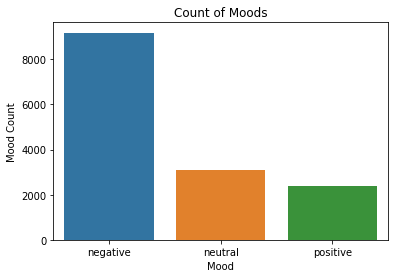

In [99]:
Mood_count = Tweet['airline_sentiment'].value_counts()

Index = [0,1,2]
sns.barplot(Index,Mood_count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

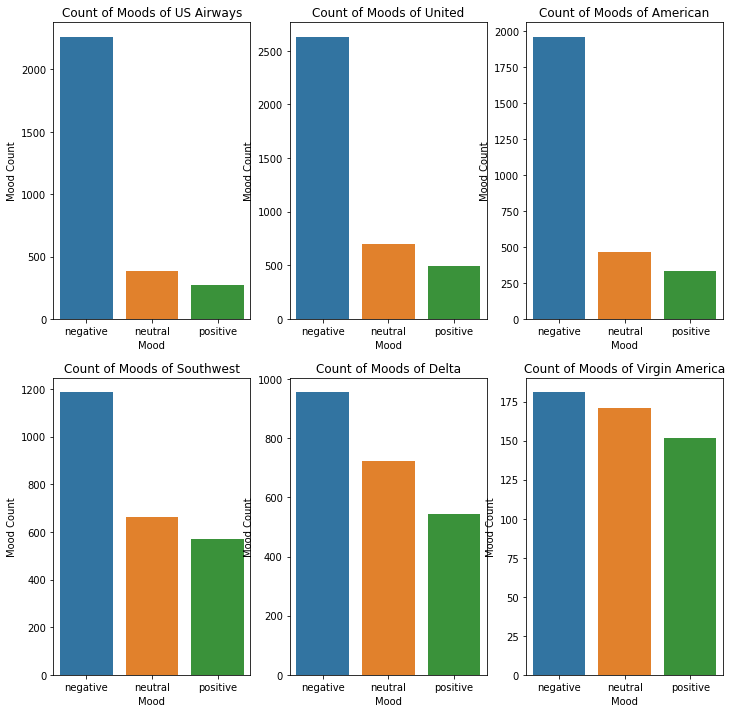

In [100]:
def plot_sub_sentiment(Airline):
    df=Tweet[Tweet['airline']==Airline]
    count=df['airline_sentiment'].value_counts()
    Index = [0,1,2]
    sns.barplot(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+Airline)
plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

From the above plots we can see that the distribution of moods for the first three airlines are always skewed toward negative moods. On contrary, the moods are distributed more balanced with the later three airline companies.

In [101]:
NR_Count=dict(Tweet['negativereason'].value_counts(sort=False))

In [102]:
def NR_Count(Airline):
    if Airline=='All':
        df=Tweet
    else:
        df=Tweet[Tweet['airline']==Airline]
    count=dict(df['negativereason'].value_counts())
    Unique_reason=list(Tweet['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [103]:
def plot_reason(Airline):
    df=NR_Count(Airline)
    count=df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

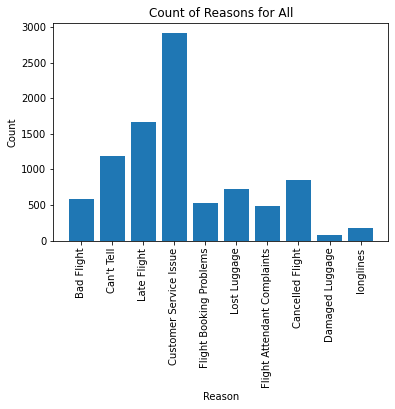

In [104]:
plot_reason('All')

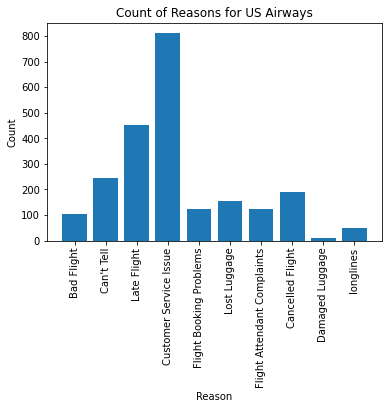

In [105]:
plot_reason('US Airways')

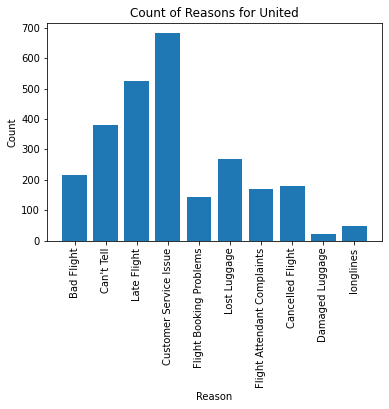

In [106]:
plot_reason('United')

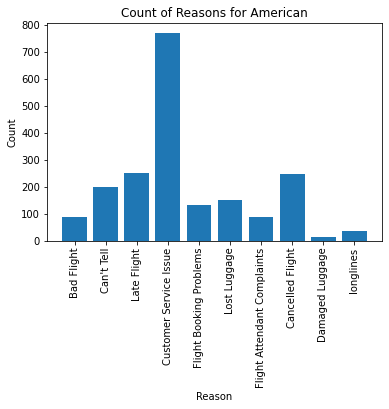

In [107]:
plot_reason('American')

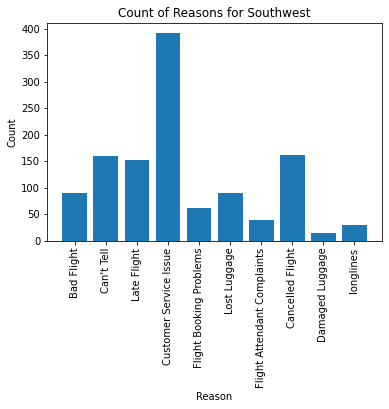

In [108]:
plot_reason('Southwest')

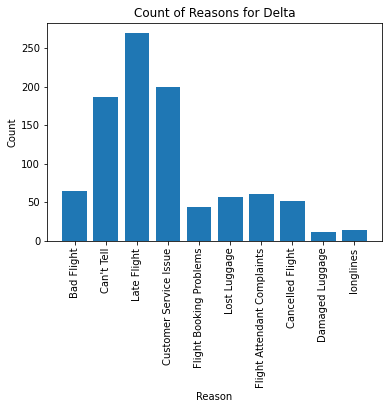

In [109]:
plot_reason('Delta')

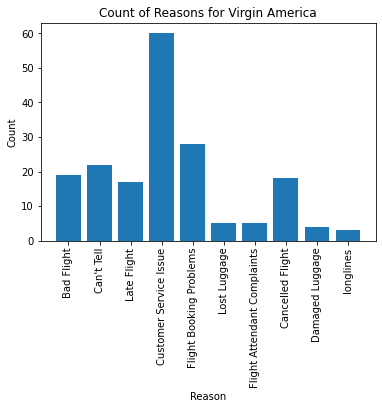

In [110]:
plot_reason('Virgin America')

## Data Preprocessing

### Data Cleaning

In [111]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)
    

In [112]:
#Drop all other columns except “text” and “airline_sentiment”.
Tweet = Tweet[['airline_sentiment', 'text']]
Tweet.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [113]:
Tweet['score']=Tweet['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1 if x=='neutral' else 2)
Tweet.head()

,airline_sentiment,text,score
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,2
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,1
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,negative,@VirginAmerica and it's a really big bad thing about it,0


In [114]:
Tweet.drop('airline_sentiment',axis=1,inplace = True)
Tweet.head()

,text,score
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0


In [115]:
#check for null values
Tweet.isnull().sum(axis=0)      

text     0
score    0
dtype: int64

In [116]:
Tweet.shape

(14640, 2)

### Data Preprocessing

#### HTML tag removal

In [117]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

Tweet['text'] = Tweet['text'].apply(lambda x: strip_html(x))
Tweet.head()

,text,score
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0


#### Replace contractions in string. (e.g. replace I'm --> I am) and so on.

In [118]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

Tweet['text'] = Tweet['text'].apply(lambda x: replace_contractions(x))
Tweet.head()

,text,score
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you have added commercials to the experience... tacky.,2
2,@VirginAmerica I did not today... Must mean I need to take another trip!,1
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",0
4,@VirginAmerica and it is a really big bad thing about it,0


#### Remove numbers

In [119]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

Tweet['text'] = Tweet['text'].apply(lambda x: remove_numbers(x))
Tweet.head(15)

,text,score
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you have added commercials to the experience... tacky.,2
2,@VirginAmerica I did not today... Must mean I need to take another trip!,1
3,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",0
4,@VirginAmerica and it is a really big bad thing about it,0
5,@VirginAmerica seriously would pay $ a flight for seats that did not have this playing.\nit is really the only bad thing about flying VA,0
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” will not go away :)",2
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpGgrEZP",1
8,"@virginamerica Well, I did not…but NOW I DO! :-D",2
9,"@VirginAmerica it was amazing, and arrived an hour early. you are too good to me.",2


#### Tokenization

In [120]:
Tweet['text'] = Tweet.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
Tweet.head()         

,text,score
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",1
1,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",2
2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]",1
3,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]",0
4,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]",0


#### Remove Stopwords and lemmatization

In [121]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))     

In [122]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

Tweet['text'] = Tweet.apply(lambda row: normalize(row['text']), axis=1)
Tweet.head()

,text,score
0,virginamerica dhepburn say,1
1,virginamerica plus add commercials experience tacky,2
2,virginamerica not today must mean need take another trip,1
3,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,0
4,virginamerica really big bad thing,0


## Vectorisation

### Using count vectorizer

In [123]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(Tweet['text'])

data_features = data_features.toarray()     

In [124]:
data_features.shape

(14640, 1000)

In [125]:
labels = Tweet['score']
labels = labels.astype('int')

In [126]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.2, random_state=42)

In [127]:
# Using Random Forest to build model for the classification of sentiment.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=42)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7284153005464482


In [128]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[1679  160   50]
 [ 224  307   49]
 [ 101   76  282]]


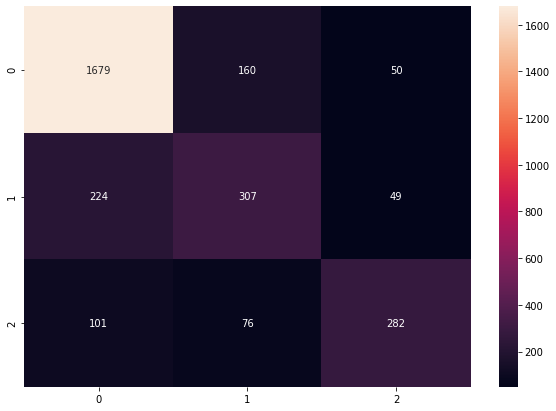

In [129]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Using Tfid Vectorizer

In [130]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(Tweet['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 1000)

In [131]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=42)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7228142076502733


In [132]:
result = forest.predict(X_test)

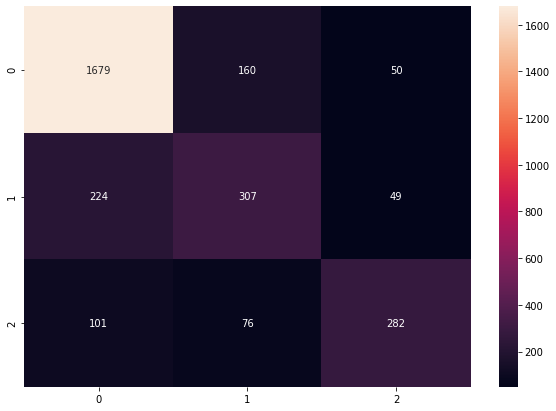

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Summary:

- the dataset used has tweets in text format and their sentiment on text format. this sentiment is change to scores by the following, negative is 0, neutral is 1 and positive is 2.
- The goal was to build a model for text-classification.
- Pre-processed the data using variuos techniques and libraries.
- The pre-precessed data is converted to numbers, so that I can feed the data in the model.
- After building the classification model, I predicted the result for the test data.
- After that, using the above techniques, the model performed good in perspective of how the text classification models perform.
- the accuray i got in both vectorisation is 72%
- One more way to increase accuracy is to use different variations of Pre-processing techniques.